In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import copy

!pip install torchmetrics
import torchmetrics

!pip install einops
import einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
!gdown https://drive.google.com/uc?id=1PHlqeEjte_ZvBdnpFAZiQXaaycqb5Ul1
#!mv Dataset_Student_annot_copy.zip Dataset_Student_annot.zip
!unzip Dataset_Student_annot.zip
#https://drive.google.com/file/d/1lWTIkjK53YfXHy8HoOH4spNyvAEiDxI2/view?usp=share_link
#https://drive.google.com/file/d/1PHlqeEjte_ZvBdnpFAZiQXaaycqb5Ul1/view?usp=share_link non copy version

Downloading...
From: https://drive.google.com/uc?id=1PHlqeEjte_ZvBdnpFAZiQXaaycqb5Ul1
To: /content/Dataset_Student_annot.zip
 14% 1.39G/10.1G [00:09<00:50, 172MB/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
import os
import os.path
import numpy as np
from PIL import Image
from torchvision import transforms
import torch
from typing import List, Union, Tuple, Any


class VideoRecord(object):
    """
    Helper class for class VideoFrameDataset. This class
    represents a video sample's metadata.

    Args:
        root_datapath: the system path to the root folder
                       of the videos.
        row: A list with four or more elements where 1) The first
             element is the path to the video sample's frames excluding
             the root_datapath prefix 2) The  second element is the starting frame id of the video
             3) The third element is the inclusive ending frame id of the video
             4) The fourth element is the label index.
             5) any following elements are labels in the case of multi-label classification
    """
    def __init__(self, row, root_datapath):
        self._data = row
        self._path = os.path.join(root_datapath, row[0])


    @property
    def path(self) -> str:
        return self._path

    @property
    def num_frames(self) -> int:
        return self.end_frame - self.start_frame + 1  # +1 because end frame is inclusive
    @property
    def start_frame(self) -> int:
        return int(self._data[1])

    @property
    def end_frame(self) -> int:
        return int(self._data[2])

    @property
    def label(self) -> Union[int, List[int]]:
        # just one label_id
        if len(self._data) == 4:
            return int(self._data[3])
        # sample associated with multiple labels
        else:
            return [int(label_id) for label_id in self._data[3:]]

class VideoFrameDataset(torch.utils.data.Dataset):
    r"""
    A highly efficient and adaptable dataset class for videos.
    Instead of loading every frame of a video,
    loads x RGB frames of a video (sparse temporal sampling) and evenly
    chooses those frames from start to end of the video, returning
    a list of x PIL images or ``FRAMES x CHANNELS x HEIGHT x WIDTH``
    tensors where FRAMES=x if the ``ImglistToTensor()``
    transform is used.

    More specifically, the frame range [START_FRAME, END_FRAME] is divided into NUM_SEGMENTS
    segments and FRAMES_PER_SEGMENT consecutive frames are taken from each segment.

    Note:
        A demonstration of using this class can be seen
        in ``demo.py``
        https://github.com/RaivoKoot/Video-Dataset-Loading-Pytorch

    Note:
        This dataset broadly corresponds to the frame sampling technique
        introduced in ``Temporal Segment Networks`` at ECCV2016
        https://arxiv.org/abs/1608.00859.


    Note:
        This class relies on receiving video data in a structure where
        inside a ``ROOT_DATA`` folder, each video lies in its own folder,
        where each video folder contains the frames of the video as
        individual files with a naming convention such as
        img_001.jpg ... img_059.jpg.
        For enumeration and annotations, this class expects to receive
        the path to a .txt file where each video sample has a row with four
        (or more in the case of multi-label, see README on Github)
        space separated values:
        ``VIDEO_FOLDER_PATH     START_FRAME      END_FRAME      LABEL_INDEX``.
        ``VIDEO_FOLDER_PATH`` is expected to be the path of a video folder
        excluding the ``ROOT_DATA`` prefix. For example, ``ROOT_DATA`` might
        be ``home\data\datasetxyz\videos\``, inside of which a ``VIDEO_FOLDER_PATH``
        might be ``jumping\0052\`` or ``sample1\`` or ``00053\``.

    Args:
        root_path: The root path in which video folders lie.
                   this is ROOT_DATA from the description above.
        annotationfile_path: The .txt annotation file containing
                             one row per video sample as described above.
        num_segments: The number of segments the video should
                      be divided into to sample frames from.
        frames_per_segment: The number of frames that should
                            be loaded per segment. For each segment's
                            frame-range, a random start index or the
                            center is chosen, from which frames_per_segment
                            consecutive frames are loaded.
        imagefile_template: The image filename template that video frame files
                            have inside of their video folders as described above.
        transform: Transform pipeline that receives a list of PIL images/frames.
        test_mode: If True, frames are taken from the center of each
                   segment, instead of a random location in each segment.

    """
    def __init__(self,
                 root_path: str,
                 annotationfile_path: str,
                 num_segments: int = 3,
                 frames_per_segment: int = 1,
                 imagefile_template: str='image_{:d}.png',
                 transform = None,
                 mask: bool =False,
                 mask_template: str='mask.npy',
                 test_mode: bool = False):
        super(VideoFrameDataset, self).__init__()

        self.root_path = root_path
        self.annotationfile_path = annotationfile_path
        self.num_segments = num_segments
        self.frames_per_segment = frames_per_segment
        self.imagefile_template = imagefile_template
        self.transform = transform
        self.mask = mask
        self.mask_template = mask_template
        self.test_mode = test_mode

        self._parse_annotationfile()
        self._sanity_check_samples()

    def _load_image(self, directory: str, idx: int) -> Image.Image:
        return Image.open(os.path.join(directory, self.imagefile_template.format(idx))).convert('RGB')
    
    def _load_mask(self, directory: str) -> torch.Tensor:
        return torch.Tensor(np.load(os.path.join(directory, self.mask_template)))

    def _parse_annotationfile(self):
        self.video_list = [VideoRecord(x.strip().split(), self.root_path) for x in open(self.annotationfile_path)]

    def _sanity_check_samples(self):
        for record in self.video_list:
            if record.num_frames <= 0 or record.start_frame == record.end_frame:
                print(f"\nDataset Warning: video {record.path} seems to have zero RGB frames on disk!\n")

            elif record.num_frames < (self.num_segments * self.frames_per_segment):
                print(f"\nDataset Warning: video {record.path} has {record.num_frames} frames "
                      f"but the dataloader is set up to load "
                      f"(num_segments={self.num_segments})*(frames_per_segment={self.frames_per_segment})"
                      f"={self.num_segments * self.frames_per_segment} frames. Dataloader will throw an "
                      f"error when trying to load this video.\n")

    def _get_start_indices(self, record: VideoRecord) -> 'np.ndarray[int]':
        """
        For each segment, choose a start index from where frames
        are to be loaded from.

        Args:
            record: VideoRecord denoting a video sample.
        Returns:
            List of indices of where the frames of each
            segment are to be loaded from.
        """
        # choose start indices that are perfectly evenly spread across the video frames.
        if self.test_mode:
            distance_between_indices = (record.num_frames - self.frames_per_segment + 1) / float(self.num_segments)

            start_indices = np.array([int(distance_between_indices / 2.0 + distance_between_indices * x)
                                      for x in range(self.num_segments)])
        # randomly sample start indices that are approximately evenly spread across the video frames.
        else:
            max_valid_start_index = (record.num_frames - self.frames_per_segment + 1) // self.num_segments

            start_indices = np.multiply(list(range(self.num_segments)), max_valid_start_index) + \
                      np.random.randint(max_valid_start_index, size=self.num_segments)

        return start_indices

    def __getitem__(self, idx: int) -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        For video with id idx, loads self.NUM_SEGMENTS * self.FRAMES_PER_SEGMENT
        frames from evenly chosen locations across the video.

        Args:
            idx: Video sample index.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """
        record: VideoRecord = self.video_list[idx]

        frame_start_indices: 'np.ndarray[int]' = self._get_start_indices(record)

        return self._get(record, frame_start_indices)

    def _get(self, record: VideoRecord, frame_start_indices: 'np.ndarray[int]') -> Union[
        Tuple[List[Image.Image], Union[int, List[int]]],
        Tuple['torch.Tensor[num_frames, channels, height, width]', Union[int, List[int]]],
        Tuple[Any, Union[int, List[int]]],
        ]:
        """
        Loads the frames of a video at the corresponding
        indices.

        Args:
            record: VideoRecord denoting a video sample.
            frame_start_indices: Indices from which to load consecutive frames from.
        Returns:
            A tuple of (video, label). Label is either a single
            integer or a list of integers in the case of multiple labels.
            Video is either 1) a list of PIL images if no transform is used
            2) a batch of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1]
            if the transform "ImglistToTensor" is used
            3) or anything else if a custom transform is used.
        """

        frame_start_indices = frame_start_indices + record.start_frame
        images = list()

        # from each start_index, load self.frames_per_segment
        # consecutive frames
        for start_index in frame_start_indices:
            frame_index = int(start_index)

            # load self.frames_per_segment consecutive frames
            for _ in range(self.frames_per_segment):
                image = self._load_image(record.path, frame_index)
                images.append(image)

                if frame_index < record.end_frame:
                    frame_index += 1

        if self.transform is not None:
            images = self.transform(images)

        if self.mask:
            mask = self._load_mask(record.path)
            return images, record.label, mask

        return images, record.label

    def __len__(self):
        return len(self.video_list)

class ImglistToTensor(torch.nn.Module):
    """
    Converts a list of PIL images in the range [0,255] to a torch.FloatTensor
    of shape (NUM_IMAGES x CHANNELS x HEIGHT x WIDTH) in the range [0,1].
    Can be used as first transform for ``VideoFrameDataset``.
    """
    @staticmethod
    def forward(img_list: List[Image.Image]) -> 'torch.Tensor[NUM_IMAGES, CHANNELS, HEIGHT, WIDTH]':
        """
        Converts each PIL image in a list to
        a torch Tensor and stacks them into
        a single tensor.

        Args:
            img_list: list of PIL images.
        Returns:
            tensor of size ``NUM_IMAGES x CHANNELS x HEIGHT x WIDTH``
        """
        return torch.stack([transforms.functional.to_tensor(pic) for pic in img_list])

In [ ]:
## IJEPA Model
import os
import torch
import torch.nn as nn
from einops import rearrange
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F
import warnings


def _no_grad_trunc_normal_(tensor, mean, std, a, b):
    def norm_cdf(x):
        # Computes standard normal cumulative distribution function
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    if (mean < a - 2 * std) or (mean > b + 2 * std):
        warnings.warn("mean is more than 2 std from [a, b] in nn.init.trunc_normal_. "
                      "The distribution of values may be incorrect.",
                      stacklevel=2)

    with torch.no_grad():
        # Values are generated by using a truncated uniform distribution and
        # then using the inverse CDF for the normal distribution.
        # Get upper and lower cdf values
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)

        # Uniformly fill tensor with values from [l, u], then translate to
        # [2l-1, 2u-1].
        tensor.uniform_(2 * l - 1, 2 * u - 1)

        # Use inverse cdf transform for normal distribution to get truncated
        # standard normal
        tensor.erfinv_()

        # Transform to proper mean, std
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)

        # Clamp to ensure it's in the proper range
        tensor.clamp_(min=a, max=b)
        return tensor

 
def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # type: (Tensor, float, float, float, float) -> Tensor
    r"""Fills the input Tensor with values drawn from a truncated
    normal distribution. The values are effectively drawn from the
    normal distribution :math:`\mathcal{N}(\text{mean}, \text{std}^2)`
    with values outside :math:`[a, b]` redrawn until they are within
    the bounds. The method used for generating the random values works
    best when :math:`a \leq \text{mean} \leq b`.
    Args:
        tensor: an n-dimensional `torch.Tensor`
        mean: the mean of the normal distribution
        std: the standard deviation of the normal distribution
        a: the minimum cutoff value
        b: the maximum cutoff value
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.trunc_normal_(w)
    """
    return _no_grad_trunc_normal_(tensor, mean, std, a, b)


def drop_path(x, drop_prob: float = 0., training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class EarlyStop:
    def __init__(self, patience, loss=False):
        self.patience = patience
        self.best_value = np.inf if loss else 0
        self.best_epoch = 0
        self.loss = loss

    def step(self, current_value, current_epoch):
        print("Current:{} Best:{}".format(current_value, self.best_value))
        if self.loss:
            if current_value < self.best_value:
                self.best_value = current_value
                self.best_epoch = current_epoch
        else:
            if current_value > self.best_value:
                self.best_value = current_value
                self.best_epoch = current_epoch

    def stop_training(self, current_epoch) -> bool:
        return current_epoch - self.best_epoch > self.patience


class CustomDataParallel(nn.DataParallel):
    """
    Wrapper for scoring with nn.DataParallel object containing LTRModel.
    """

    def forward(self, x):
        return self.module.forward(x)  # type: ignore


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = img_size, img_size
        patch_size = patch_size, patch_size
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, T, H, W = x.shape
        x = rearrange(x, 'b c t h w -> (b t) c h w')
        x = self.proj(x)
        W = x.size(-1)
        x = x.flatten(2).transpose(1, 2)
        return x, T, W

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., with_qkv=True):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.with_qkv = with_qkv
        if self.with_qkv:
           self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
           self.proj = nn.Linear(dim, dim)
           self.proj_drop = nn.Dropout(proj_drop)
        self.attn_drop = nn.Dropout(attn_drop)

    def forward(self, x):
        B, N, C = x.shape
        if self.with_qkv:
           qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
           q, k, v = qkv[0], qkv[1], qkv[2]
        else:
           qkv = x.reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
           q, k, v  = qkv, qkv, qkv

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        if self.with_qkv:
           x = self.proj(x)
           x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0.1, act_layer=nn.GELU, norm_layer=nn.LayerNorm, attention_type='divided_space_time'):
        super().__init__()
        self.attention_type = attention_type
        assert(attention_type in ['divided_space_time', 'space_only','joint_space_time'])

        self.norm1 = norm_layer(dim)
        self.attn = Attention(
           dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        ## Temporal Attention Parameters
        if self.attention_type == 'divided_space_time':
            self.temporal_norm1 = norm_layer(dim)
            self.temporal_attn = Attention(
              dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
            self.temporal_fc = nn.Linear(dim, dim)

        ## drop path
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)


    def forward(self, x, B, T, W):
        num_spatial_tokens = (x.size(1) - 1) // T
        H = num_spatial_tokens // W

        if self.attention_type in ['space_only', 'joint_space_time']:
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x
        elif self.attention_type == 'divided_space_time':
            ## Temporal
            xt = x # xt = x[:,1:,:]
            xt = rearrange(xt, 'b (h w t) m -> (b h w) t m',b=B,w=W,t=T)
            res_temporal = self.drop_path(self.temporal_attn(self.temporal_norm1(xt)))
            res_temporal = rearrange(res_temporal, '(b h w) t m -> b (h w t) m',b=B,w=W,t=T)
            res_temporal = self.temporal_fc(res_temporal)
            xt = x + res_temporal # xt = x[:,1:,:] + res_temporal

            ## Spatial
            # init_cls_token = x[:,0,:].unsqueeze(1)
            # cls_token = init_cls_token.repeat(1, T, 1)
            # cls_token = rearrange(cls_token, 'b t m -> (b t) m',b=B,t=T).unsqueeze(1)
            xs = xt
            xs = rearrange(xs, 'b (h w t) m -> (b t) (h w) m',b=B,w=W,t=T)
            # xs = torch.cat((cls_token, xs), 1)
            res_spatial = self.drop_path(self.attn(self.norm1(xs)))

            ### Taking care of CLS token
            # cls_token = res_spatial[:,0,:]
            # cls_token = rearrange(cls_token, '(b t) m -> b t m',b=B,t=T)
            # cls_token = torch.mean(cls_token,1,True) ## averaging for every frame
            # res_spatial = res_spatial[:,1:,:]
            res_spatial = rearrange(res_spatial, '(b t) (h w) m -> b (h w t) m',b=B,w=W,t=T)
            res = res_spatial
            x = xt

            ## Mlp
            x = x + res # x = torch.cat((init_cls_token, x), 1) + torch.cat((cls_token, res), 1)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x


class VisionTransformer(nn.Module):
    """ Vision Transformer
    """
    def __init__(self,
                embed_dim=768,
                depth=12,
                num_heads=12,
                mlp_ratio=4.,
                qkv_bias=False,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.1,
                norm_layer=nn.LayerNorm,
                attention_type='divided_space_time',
                dropout=0.):
        super().__init__()
        self.attention_type = attention_type
        self.depth = depth
        self.dropout = nn.Dropout(dropout)
        self.num_features = self.embed_dim = embed_dim

        ## Attention Blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, self.depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, attention_type=self.attention_type)
            for i in range(self.depth)])
        self.norm = norm_layer(embed_dim)

        ## initialization of temporal attention weights
        if self.attention_type == 'divided_space_time':
            i = 0
            for m in self.blocks.modules():
                m_str = str(m)
                if 'Block' in m_str:
                    if i > 0:
                      nn.init.constant_(m.temporal_fc.weight, 0)
                      nn.init.constant_(m.temporal_fc.bias, 0)
                    i += 1

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x, B, T, W):

        ## Attention blocks
        for blk in self.blocks:
            x = blk(x, B, T, W)

        ### Predictions for space-only baseline
        if self.attention_type == 'space_only':
            x = rearrange(x, '(b t) n m -> b t n m',b=B,t=T)
            x = torch.mean(x, 1) # averaging predictions for every frame

        x = self.norm(x)
        # x = rearrange(x, 'b (h w t) m -> b t (h w) m',b=B,t=T,w=W)
        return x
    
    
class IJEPA_base(nn.Module):
    def __init__(self,
                img_size=224,
                patch_size=16,
                in_chans=3,
                norm_layer=nn.LayerNorm,
                num_frames=22,
                attention_type='joint_space_time',
                dropout=0.,
                mode="train",
                r=0.5,
                embed_dim=768,
                device='cuda',
                # encoder parameters
                enc_depth=12,
                enc_num_heads=12,
                enc_mlp_ratio=4.,
                enc_qkv_bias=False,
                enc_qk_scale=None,
                enc_drop_rate=0.,
                enc_attn_drop_rate=0.,
                enc_drop_path_rate=0.1,
                # predictor parameters
                pred_depth=12,
                pred_num_heads=12,
                pred_mlp_ratio=4.,
                pred_qkv_bias=False,
                pred_qk_scale=None,
                pred_drop_rate=0.,
                pred_attn_drop_rate=0.,
                pred_drop_path_rate=0.1,
                # positional and spacial embedding parameters
                pos_drop_rate=0.,
                time_drop_rate=0.):
        super().__init__()
        self.mode = mode
        self.dropout = dropout
        self.mask_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        nn.init.trunc_normal_(self.mask_token, 0.02)
        self.r = r # number of masked frames

        self.norm_layer = norm_layer
        self.norm = norm_layer(embed_dim)

        self.attention_type = attention_type

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim)) # self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, embed_dim))
        self.pos_drop = nn.Dropout(p=pos_drop_rate)

        if self.attention_type != 'space_only':
            self.time_embed = nn.Parameter(torch.zeros(1, num_frames, embed_dim))
            self.time_drop = nn.Dropout(p=time_drop_rate)

        self.teacher_encoder = VisionTransformer(
            embed_dim=embed_dim,
            num_heads=enc_num_heads,
            depth=enc_depth, 
            dropout=self.dropout,
            norm_layer=self.norm_layer,
            mlp_ratio=enc_mlp_ratio,
            attention_type=attention_type,
            qkv_bias=enc_qkv_bias,
            qk_scale=enc_qk_scale,
            drop_rate=enc_drop_rate,
            attn_drop_rate=enc_attn_drop_rate,
            drop_path_rate=enc_drop_path_rate
        )

        self.student_encoder = copy.deepcopy(self.teacher_encoder)
        self.predictor = VisionTransformer(
            embed_dim=embed_dim,
            num_heads=pred_num_heads,
            depth=pred_depth, 
            dropout=self.dropout,
            norm_layer=self.norm_layer,
            mlp_ratio=pred_mlp_ratio,
            attention_type=attention_type,
            qkv_bias=pred_qkv_bias,
            qk_scale=pred_qk_scale,
            drop_rate=pred_drop_rate,
            attn_drop_rate=pred_attn_drop_rate,
            drop_path_rate=pred_drop_path_rate
        )
        

    @torch.no_grad() 
    ### get the target block
    def get_target_block(self, target_encoder, x, B, T, W):  
        #get the target block
        target_encoder = target_encoder.eval()
        x = target_encoder(x, B, T, W) # input in format 'b (t h w) m',output in format 'b (t h w) m' (batch frames n_patches embed_dim)
        x = self.norm(x)
        tn = x.shape[1]

        #randomly select M frames to mask in x
        p = int(tn * self.r)
        mask_indices = (torch.randperm(tn))[:p]
        
        #mask the selected frames in the context block
        target_block = x[:,mask_indices] #get portion of random patches from rnadom frames
        #all_patches = x
        return target_block, mask_indices

    ### get the context block
    def get_context_block(self, x, mask_indices):
      #reshape x to format 'b t (h w) m'
      # x = rearrange(x, 'b (t h w) m -> b t (h w) m',b=B,t=T,w=W)
      #select all frames which are not masked
      index = torch.ones(x.shape[1], dtype=bool)
      index[mask_indices] = False
      context_block = x[:,index]
      # context_block = rearrange(context_block, 'b t (h w) m -> b (t h w) m',b=B,t=(T-self.M),w=W)
      return context_block
    
    def get_patch_embeddings(self, x):
        B = x.shape[0]
        x, T, W = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        if self.attention_type != 'space_only':
            x = rearrange(x, '(b t) n m -> (b n) t m',b=B,t=T)
            if T != self.time_embed.size(1):
                time_embed = self.time_embed.transpose(1, 2)
                new_time_embed = F.interpolate(time_embed, size=(T), mode='nearest')
                new_time_embed = new_time_embed.transpose(1, 2)
                x = x + new_time_embed
            else:
                x = x + self.time_embed
            x = self.time_drop(x)
            x = rearrange(x, '(b n) t m -> b (n t) m',b=B,t=T)
            
        return x, B, T, W
    
    def forward(self, x):
        #get the patch embeddings
        x, B, T, W = self.get_patch_embeddings(x)

        #if mode is test, we get return full embedding:
        if self.mode == 'test':
            encoding = self.student_encoder(x, B, T, W) # input in format 'b (t h w) m',output in format 'b t (h w) m' (batch frames n_patches embed_dim)
            encoding = self.norm(encoding)
            b, n, m = encoding.shape
            # encoding = rearrange(encoding, 'b t (h w) m -> b (t h w) m',b=B,t=T,w=W)
            #add 11 mask tokens to the end of the embedding
            target_masks = self.mask_token.repeat(B, n, 1)
            target_pos_embedding = self.pos_embed.unsqueeze(1)
            # Add time embedding
            target_time_embed = self.time_embed.unsqueeze(2)[:,11:]

            target_embeddings = target_pos_embedding + target_time_embed
            target_embeddings = rearrange(target_embeddings, 'b t n m -> b (t n) m')
            target_masks = target_masks + target_embeddings
            
            # target_masks = rearrange(target_masks, 'b t (h w) m -> b (t h w) m',b=B,t=11,w=W)
            encoding = torch.cat((encoding, target_masks), dim=1)
            encodings_plus_predicted = self.predictor(encoding, B, T+11, W)
            return encodings_plus_predicted # predict the masked frames
        
        # #get target embeddings
        # input in format 'b (t h w) m', output in format (1) 'b 11 (h w) m' and (2) 'b t (h w) m'
        target_blocks, mask_indices = self.get_target_block(self.teacher_encoder,x,B,T,W)

        #get context embeddings
        context_block = self.get_context_block(x, mask_indices)

        context_encoding = self.student_encoder(context_block, B, T, W)
        context_encoding = self.norm(context_encoding)
        # context_encoding = rearrange(context_encoding, 'b t (h w) m -> b (t h w) m',b=B,t=T-self.M,w=W)

        #n = h x w
        b, p, m = target_blocks.shape
        target_masks = self.mask_token.repeat(B, p, 1)

        # Add time embedding and position embedding
        target_pos_embedding = self.pos_embed.unsqueeze(1)
        target_time_embed = self.time_embed.unsqueeze(2)
        target_embeddings = target_pos_embedding + target_time_embed
        target_embeddings = rearrange(target_embeddings, 'b t n m -> b (t n) m')[:, mask_indices]


        target_masks = target_masks + target_embeddings
        # target_masks = rearrange(target_masks, 'b t (h w) m -> b (t h w) m',b=B,t=self.M,w=W)
        prediction_cat = torch.cat((context_encoding, target_masks), dim = 1)
        # make sure that the preds are actually at the end
        prediction_blocks = self.predictor(prediction_cat,B, T, W)

        prediction_blocks = prediction_blocks[:,-p:]
        return prediction_blocks, target_blocks, context_encoding

In [ ]:
### Load the encoder
encoder = IJEPA_base(img_size=128, patch_size=16, in_chans=3, norm_layer=nn.LayerNorm, num_frames=22, attention_type='joint_space_time', dropout=0.1, mode="train", r=0.5, embed_dim=768, device=device,
                        # encoder parameters
                        enc_depth=4,
                        enc_num_heads=6,
                        enc_mlp_ratio=4.,
                        enc_qkv_bias=False,
                        enc_qk_scale=None,
                        enc_drop_rate=0.,
                        enc_attn_drop_rate=0.,
                        enc_drop_path_rate=0.1,
                        # predictor parameters
                        pred_depth=4,
                        pred_num_heads=6,
                        pred_mlp_ratio=4.,
                        pred_qkv_bias=False,
                        pred_qk_scale=None,
                        pred_drop_rate=0.1,
                        pred_attn_drop_rate=0.1,
                        pred_drop_path_rate=0.1,
                        # positional and spacial embedding parameters
                        pos_drop_rate=0.1,
                        time_drop_rate=0.1)
# Leave this to load properly the optimizer dict
encoder.to(device)

encoder_saved_data = torch.load("best_model.pkl", map_location=device)
encoder.load_state_dict(encoder_saved_data)

<All keys matched successfully>

In [ ]:
### DECODER
import os
import torch
import torch.nn as nn
from einops import rearrange
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F
import warnings
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from typing import Optional
import math
from functools import partial

def trunc_normal_init(module: nn.Module,
                      mean: float = 0,
                      std: float = 1,
                      a: float = -2,
                      b: float = 2,
                      bias: float = 0) -> None:
    if hasattr(module, 'weight') and module.weight is not None:
        trunc_normal_(module.weight, mean, std, a, b)  # type: ignore
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)  # type: ignore

def constant_init(module, val, bias=0):
    if hasattr(module, 'weight') and module.weight is not None:
        nn.init.constant_(module.weight, val)
    if hasattr(module, 'bias') and module.bias is not None:
        nn.init.constant_(module.bias, bias)

class TPN_Decoder(TransformerDecoder):
    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None, tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None):
        output = tgt
        # attns = []
        # for mod in self.layers:
        #     output, attn = mod(output, memory, tgt_mask=tgt_mask,
        #                  memory_mask=memory_mask,
        #                  tgt_key_padding_mask=tgt_key_padding_mask,
        #                  memory_key_padding_mask=memory_key_padding_mask)
            # attns.append(attn)

        output, attn = self.layers[0](output, memory, tgt_mask=tgt_mask,
                          memory_mask=memory_mask,
                          tgt_key_padding_mask=tgt_key_padding_mask,
                          memory_key_padding_mask=memory_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output, attn

class TPN_DecoderLayer(TransformerDecoderLayer):
    def __init__(self, **kwargs):
        super(TPN_DecoderLayer, self).__init__(**kwargs)
        del self.multihead_attn
        self.multihead_attn = Attention(
            kwargs['d_model'], num_heads=kwargs['nhead'], qkv_bias=True, attn_drop=0.1)

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Optional[Tensor] = None,
                memory_mask: Optional[Tensor] = None,
                tgt_key_padding_mask: Optional[Tensor] = None,
                memory_key_padding_mask: Optional[Tensor] = None) -> Tensor:
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2, attn2 = self.multihead_attn(
            tgt.transpose(0, 1), memory.transpose(0, 1), memory.transpose(0, 1))
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt, attn2

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.k = nn.Linear(dim, dim, bias=qkv_bias)
        self.v = nn.Linear(dim, dim, bias=qkv_bias)

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, xq, xk, xv):
        B, Nq, C = xq.size()
        Nk = xk.size()[1]
        Nv = xv.size()[1]

        q = self.q(xq).reshape(B, Nq, self.num_heads,
                                      C // self.num_heads).permute(0, 2, 1, 3)
        k = self.k(xk).reshape(B, Nk, self.num_heads,
                                      C // self.num_heads).permute(0, 2, 1, 3)
        v = self.v(xv).reshape(B, Nv, self.num_heads,
                                      C // self.num_heads).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_save = attn.clone()
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, Nq, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x.transpose(0, 1), attn_save.sum(dim=1) / self.num_heads


class MLP(nn.Module):
    """Very simple multi-layer perceptron (also called FFN)"""

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim])
        )

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x
    

def accuracy(pred, target, topk=1, thresh=None, ignore_index=None):
    """Calculate accuracy according to the prediction and target.
    Args:
        pred (torch.Tensor): The model prediction, shape (N, num_class, ...)
        target (torch.Tensor): The target of each prediction, shape (N, , ...)
        ignore_index (int | None): The label index to be ignored. Default: None
        topk (int | tuple[int], optional): If the predictions in ``topk``
            matches the target, the predictions will be regarded as
            correct ones. Defaults to 1.
        thresh (float, optional): If not None, predictions with scores under
            this threshold are considered incorrect. Default to None.
    Returns:
        float | tuple[float]: If the input ``topk`` is a single integer,
            the function will return a single float as accuracy. If
            ``topk`` is a tuple containing multiple integers, the
            function will return a tuple containing accuracies of
            each ``topk`` number.
    """
    assert isinstance(topk, (int, tuple))
    if isinstance(topk, int):
        topk = (topk, )
        return_single = True
    else:
        return_single = False

    maxk = max(topk)
    if pred.size(0) == 0:
        accu = [pred.new_tensor(0.) for i in range(len(topk))]
        return accu[0] if return_single else accu
    assert pred.ndim == target.ndim + 1
    assert pred.size(0) == target.size(0)
    assert maxk <= pred.size(1), \
        f'maxk {maxk} exceeds pred dimension {pred.size(1)}'
    pred_value, pred_label = pred.topk(maxk, dim=1)
    # transpose to shape (maxk, N, ...)
    pred_label = pred_label.transpose(0, 1)
    correct = pred_label.eq(target.unsqueeze(0).expand_as(pred_label))
    if thresh is not None:
        # Only prediction values larger than thresh are counted as correct
        correct = correct & (pred_value > thresh).t()
    if ignore_index is not None:
        correct = correct[:, target != ignore_index]
    res = []
    eps = torch.finfo(torch.float32).eps
    for k in topk:
        # Avoid causing ZeroDivisionError when all pixels
        # of an image are ignored
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True) + eps
        if ignore_index is not None:
            total_num = target[target != ignore_index].numel() + eps
        else:
            total_num = target.numel() + eps
        res.append(correct_k.mul_(100.0 / total_num))
    return res[0] if return_single else res

class ATMHead(nn.Module):
    def __init__(
            self,
            img_size,
            H,
            W,
            in_channels,
            embed_dims=768,
            num_layers=3,
            num_heads=8,
            use_stages=3,
            use_proj=True,
            CE_loss=False,
            crop_train=False,
            #shrink_ratio=None,
            #**kwargs,

            num_classes=48
    ):
        
        super().__init__()

        # super(ATMHead, self).__init__()
         #   in_channels=in_channels, **kwargs)

        self.in_channels = in_channels
        self.num_classes = num_classes

        self.image_size = img_size
        self.H = H
        self.W = W

        self.use_stages = use_stages
        self.crop_train = crop_train
        nhead = num_heads
        dim = embed_dims
        input_proj = []
        proj_norm = []
        atm_decoders = []
        for i in range(self.use_stages):
            # FC layer to change ch
            if use_proj:
                proj = nn.Linear(self.in_channels, dim)
                trunc_normal_(proj.weight, std=.02)
            else:
                proj = nn.Identity()
            self.add_module("input_proj_{}".format(i + 1), proj)
            input_proj.append(proj)
            # norm layer
            if use_proj:
                norm = nn.LayerNorm(dim)
            else:
                norm = nn.Identity()
            self.add_module("proj_norm_{}".format(i + 1), norm)
            proj_norm.append(norm)
            # decoder layer
            decoder_layer = TPN_DecoderLayer(d_model=dim, nhead=nhead, dim_feedforward=dim * 4)
            decoder = TPN_Decoder(decoder_layer, num_layers)
            self.add_module("decoder_{}".format(i + 1), decoder)
            atm_decoders.append(decoder)

        self.input_proj = input_proj
        self.proj_norm = proj_norm
        self.decoder = atm_decoders
        self.q = nn.Embedding(self.num_classes + 1, dim) # nn.Embedding(self.num_classes, dim)

        self.class_embed = nn.Linear(dim, self.num_classes + 1)
        self.CE_loss = CE_loss
        # delattr(self, 'conv_seg')

    def init_weights(self):
        for n, m in self.named_modules():
            if isinstance(m, nn.Linear):
                trunc_normal_init(m, std=.02, bias=0)
            elif isinstance(m, nn.LayerNorm):
                constant_init(m, val=1.0, bias=0.0)

    def forward(self, inputs):
        x = []
        # for stage_ in inputs[:self.use_stages]:
        #     x.append(self.d4_to_d3(stage_) if stage_.dim() > 3 else stage_)

        x.append(self.d4_to_d3(inputs) if inputs.dim() > 3 else inputs)

        x.reverse()
        bs = x[0].size()[0]

        laterals = []
        attns = []
        maps_size = []
        qs = []
        q = self.q.weight.repeat(bs, 1, 1).transpose(0, 1)

        for idx, (x_, proj_, norm_, decoder_) in enumerate(zip(x, self.input_proj, self.proj_norm, self.decoder)):
            lateral = norm_(proj_(x_))
            # if idx == 0:
            if True:
                laterals.append(lateral)
            else:
                if laterals[idx - 1].size()[1] == lateral.size()[1]:
                    laterals.append(lateral + laterals[idx - 1])
                else:
                    # nearest interpolate
                    l_ = self.d3_to_d4(laterals[idx - 1])
                    l_ = F.interpolate(l_, scale_factor=2, mode="nearest")
                    l_ = self.d4_to_d3(l_)
                    laterals.append(l_ + lateral)

            #print(q.shape)
            #print(lateral.shape)
            
            q, attn = decoder_(q, lateral.transpose(0, 1))
            attn = attn.transpose(-1, -2)
            if self.crop_train and self.training:
                blank_attn = torch.zeros_like(attn)
                blank_attn = blank_attn[:, 0].unsqueeze(1).repeat(1, (self.image_size//16)**2, 1)
                blank_attn[:, inputs[-1]] = attn
                attn = blank_attn
                self.crop_idx = inputs[-1]
            attn = self.d3_to_d4(attn)
            maps_size.append(attn.size()[-2:])
            qs.append(q.transpose(0, 1))
            attns.append(attn)
        qs = torch.stack(qs, dim=0)
        outputs_class = self.class_embed(qs)
        out = {"pred_logits": outputs_class[-1]}

        outputs_seg_masks = []
        size = maps_size[-1]

        for i_attn, attn in enumerate(attns):
            if i_attn == 0:
                outputs_seg_masks.append(F.interpolate(attn, size=size, mode='bilinear', align_corners=False))
            else:
                outputs_seg_masks.append(outputs_seg_masks[i_attn - 1] +
                                         F.interpolate(attn, size=size, mode='bilinear', align_corners=False))

        out["pred_masks"] = F.interpolate(outputs_seg_masks[-1],
                                          #size=(self.image_size, self.image_size),
                                          size=(self.H, self.W),
                                          mode='bilinear', align_corners=False)

        out["pred"] = self.semantic_inference(out["pred_logits"], out["pred_masks"])

        if self.training:
            # [l, bs, queries, embed]
            outputs_seg_masks = torch.stack(outputs_seg_masks, dim=0)
            out["aux_outputs"] = self._set_aux_loss(
                outputs_class, outputs_seg_masks
            )
        else:
            return out["pred"]

        return out

    @torch.jit.unused
    def _set_aux_loss(self, outputs_class, outputs_seg_masks):
        # this is a workaround to make torchscript happy, as torchscript
        # doesn't support dictionary with non-homogeneous values, such
        # as a dict having both a Tensor and a list.
        return [
            {"pred_logits": a, "pred_masks": b}
            for a, b in zip(outputs_class[:-1], outputs_seg_masks[:-1])
        ]

    def semantic_inference(self, mask_cls, mask_pred):
        mask_cls = F.softmax(mask_cls, dim=-1)[..., :]
        mask_pred = mask_pred.sigmoid()
        semseg = torch.einsum("bqc,bqhw->bchw", mask_cls, mask_pred)
        return semseg

    def d3_to_d4(self, t):
        n, hw, c = t.size()
        if hw % 2 != 0:
            t = t[:, 1:]
        h = w = int(math.sqrt(hw))
        return t.transpose(1, 2).reshape(n, c, h, w)

    def d4_to_d3(self, t):
        return t.flatten(-2).transpose(-1, -2)

    # @force_fp32(apply_to=('seg_logit',))
    def losses(self, seg_logit, seg_label):
        """Compute segmentation loss."""
        if self.CE_loss:
            return super().losses(seg_logit["pred"], seg_label)

        if isinstance(seg_logit, dict):
            # atm loss
            seg_label = seg_label.squeeze(1)
            if self.crop_train:
                # mask seg_label by crop_idx
                bs, h, w = seg_label.size()
                mask_label = seg_label.reshape(bs, h//16, 16, w//16, 16)\
                    .permute(0, 1, 3, 2, 4).reshape(bs, h*w//256, 256)
                empty_label = torch.zeros_like(mask_label) + self.ignore_index
                empty_label[:, self.crop_idx] = mask_label[:, self.crop_idx]
                seg_label = empty_label.reshape(bs, h//16, w//16, 16, 16)\
                    .permute(0, 1, 3, 2, 4).reshape(bs, h, w)
            loss = self.loss_decode(
                seg_logit,
                seg_label,
                ignore_index=self.ignore_index)

            loss['acc_seg'] = accuracy(seg_logit["pred"], seg_label, ignore_index=self.ignore_index)
            return loss

In [ ]:
### ATM Losses
from typing import List, Optional

import torch
import torch.nn as nn
import torch.distributed as dist
import torchvision
from torch import Tensor

from einops import rearrange
# import imageio.v3 as iio
import numpy as np
import copy
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import math
import torch.nn.functional as F


def _max_by_axis(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes


class NestedTensor(object):
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        # type: (Device) -> NestedTensor # noqa
        cast_tensor = self.tensors.to(device)
        mask = self.mask
        if mask is not None:
            assert mask is not None
            cast_mask = mask.to(device)
        else:
            cast_mask = None
        return NestedTensor(cast_tensor, cast_mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)


def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:
        if torchvision._is_tracing():
            # nested_tensor_from_tensor_list() does not export well to ONNX
            # call _onnx_nested_tensor_from_tensor_list() instead
            return _onnx_nested_tensor_from_tensor_list(tensor_list)

        # TODO make it support different-sized images
        max_size = _max_by_axis([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        mask = torch.ones((b, h, w), dtype=torch.bool, device=device)
        for img, pad_img, m in zip(tensor_list, tensor, mask):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
            m[: img.shape[1], : img.shape[2]] = False
    else:
        raise ValueError("not supported")
    return NestedTensor(tensor, mask)


# _onnx_nested_tensor_from_tensor_list() is an implementation of
# nested_tensor_from_tensor_list() that is supported by ONNX tracing.
@torch.jit.unused
def _onnx_nested_tensor_from_tensor_list(tensor_list: List[Tensor]) -> NestedTensor:
    max_size = []
    for i in range(tensor_list[0].dim()):
        max_size_i = torch.max(
            torch.stack([img.shape[i] for img in tensor_list]).to(torch.float32)
        ).to(torch.int64)
        max_size.append(max_size_i)
    max_size = tuple(max_size)

    # work around for
    # pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    # m[: img.shape[1], :img.shape[2]] = False
    # which is not yet supported in onnx
    padded_imgs = []
    padded_masks = []
    for img in tensor_list:
        padding = [(s1 - s2) for s1, s2 in zip(max_size, tuple(img.shape))]
        padded_img = torch.nn.functional.pad(img, (0, padding[2], 0, padding[1], 0, padding[0]))
        padded_imgs.append(padded_img)

        m = torch.zeros_like(img[0], dtype=torch.int, device=img.device)
        padded_mask = torch.nn.functional.pad(m, (0, padding[2], 0, padding[1]), "constant", 1)
        padded_masks.append(padded_mask.to(torch.bool))

    tensor = torch.stack(padded_imgs)
    mask = torch.stack(padded_masks)

    return NestedTensor(tensor, mask=mask)


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

def get_world_size() -> int:
    if not dist.is_available():
        return 1
    if not dist.is_initialized():
        return 1
    return dist.get_world_size()


def dice_loss(inputs, targets, num_masks):
    """
    Compute the DICE loss, similar to generalized IOU for masks
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
    """
    inputs = inputs.sigmoid()
    inputs = inputs.flatten(1)
    numerator = 2 * (inputs * targets).sum(-1)
    denominator = inputs.sum(-1) + targets.sum(-1)
    loss = 1 - (numerator + 1) / (denominator + 1)
    return loss.sum() / num_masks


def sigmoid_focal_loss(inputs, targets, num_masks, alpha: float = 0.25, gamma: float = 2):
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
    Returns:
        Loss tensor
    """
    prob = inputs.sigmoid()
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = prob * targets + (1 - prob) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    return loss.mean(1).sum() / num_masks


class SetCriterion(nn.Module):
    """This class computes the loss for DETR.
    The process happens in two steps:
        1) we compute hungarian assignment between ground truth boxes and the outputs of the model
        2) we supervise each pair of matched ground-truth / prediction (supervise class and box)
    """

    def __init__(self, num_classes, weight_dict, losses, eos_coef=0.001):
        """Create the criterion.
        Parameters:
            num_classes: number of object categories, omitting the special no-object category
            matcher: module able to compute a matching between targets and proposals
            weight_dict: dict containing as key the names of the losses and as values their relative weight.
            eos_coef: relative classification weight applied to the no-object category
            losses: list of all the losses to be applied. See get_loss for list of available losses.
        """
        super().__init__()
        self.num_classes = num_classes
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes)
        empty_weight[0] = self.eos_coef
        self.register_buffer("empty_weight", empty_weight)

    def loss_labels(self, outputs, targets, indices, num_masks):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert "pred_logits" in outputs
        src_logits = outputs["pred_logits"]

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.zeros(
            src_logits.shape[:2], dtype=torch.int64, device=src_logits.device
        )
        target_classes[idx] = target_classes_o.long()

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {"loss_ce": loss_ce}
        return losses

    def loss_masks(self, outputs, targets, indices, num_masks):
        """Compute the losses related to the masks: the focal loss and the dice loss.
        targets dicts must contain the key "masks" containing a tensor of dim [nb_target_boxes, h, w]
        """
        assert "pred_masks" in outputs

        src_idx = self._get_src_permutation_idx(indices)
        tgt_idx = self._get_tgt_permutation_idx(indices)
        src_masks = outputs["pred_masks"]
        if src_masks.dim() != 4:
            return {"no_loss": 0}
        src_masks = src_masks[src_idx]
        masks = [t["masks"] for t in targets]
        # TODO use valid to mask invalid areas due to padding in loss
        target_masks, valid = nested_tensor_from_tensor_list(masks).decompose()
        target_masks = target_masks.to(src_masks)
        target_masks = target_masks[tgt_idx]

        # upsample predictions to the target size
        src_masks = F.interpolate(
            src_masks[:, None], size=target_masks.shape[-2:], mode="bilinear", align_corners=False
        )
        src_masks = src_masks[:, 0].flatten(1)

        target_masks = target_masks.flatten(1)
        target_masks = target_masks.view(src_masks.shape)
        losses = {
            "loss_mask": sigmoid_focal_loss(src_masks, target_masks, num_masks),
            "loss_dice": dice_loss(src_masks, target_masks, num_masks),
        }
        return losses

    def _get_src_permutation_idx(self, indices):
        # permute predictions following indices
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx.long(), src_idx.long()

    def _get_tgt_permutation_idx(self, indices):
        # permute targets following indices
        batch_idx = torch.cat([torch.full_like(tgt, i) for i, (_, tgt) in enumerate(indices)])
        tgt_idx = torch.cat([tgt for (_, tgt) in indices])
        return batch_idx, tgt_idx

    def get_loss(self, loss, outputs, targets, indices, num_masks):
        loss_map = {"labels": self.loss_labels, "masks": self.loss_masks}
        assert loss in loss_map, f"do you really want to compute {loss} loss?"
        return loss_map[loss](outputs, targets, indices, num_masks)

    def forward(self, outputs, targets):
        """This performs the loss computation.
        Parameters:
             outputs: dict of tensors, see the output specification of the model for the format
             targets: list of dicts, such that len(targets) == batch_size.
                      The expected keys in each dict depends on the losses applied, see each loss' doc
        """
        # outputs_without_aux = {k: v for k, v in outputs.items() if k != "aux_outputs"}

        # Retrieve the matching between the outputs of the last layer and the targets

        labels = [x['labels'] for x in targets]
        indices_new = []
        for label in labels:
            t = torch.arange(len(label))
            indices_new.append([label, t])
        indices = indices_new
        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_masks = sum(len(t["labels"]) for t in targets)
        num_masks = torch.as_tensor(
            [num_masks], dtype=torch.float, device=next(iter(outputs.values())).device
        )
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_masks)
        num_masks = torch.clamp(num_masks / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_masks))

        # In case of auxiliary losses, we repeat this process with the output of each intermediate layer.
        if "aux_outputs" in outputs:
            for i, aux_outputs in enumerate(outputs["aux_outputs"]):
                # use the indices as the last stage
                for loss in self.losses:
                    l_dict = self.get_loss(loss, aux_outputs, targets, indices, num_masks)
                    l_dict = {k + f"_{i}": v for k, v in l_dict.items()}
                    losses.update(l_dict)

        return losses
    

class ATMLoss(nn.Module):
    """ATMLoss.

    """

    def __init__(self,
                 num_classes,
                 dec_layers,
                 mask_weight=20.0,
                 dice_weight=1.0,
                 cls_weight=1.0,
                 loss_weight=1.0):
        super(ATMLoss, self).__init__()
        weight_dict = {"loss_ce": cls_weight, "loss_mask": mask_weight, "loss_dice": dice_weight}
        aux_weight_dict = {}
        for i in range(dec_layers - 1):
            aux_weight_dict.update({k + f"_{i}": v for k, v in weight_dict.items()})
        weight_dict.update(aux_weight_dict)
        
        self.criterion = SetCriterion(
                num_classes,
                weight_dict=weight_dict,
                losses=["labels", "masks"],
            )
        self.loss_weight = loss_weight

    def forward(self,
                outputs,
                label,
                ignore_index,
                ):
        """Forward function."""
        self.ignore_index = ignore_index
        targets = self.prepare_targets(label)
        losses = self.criterion(outputs, targets)
        loss = 0

        for k in list(losses.keys()):
            if k in self.criterion.weight_dict:
                # losses[k] = losses[k] * self.criterion.weight_dict[k] * self.loss_weight
                loss += losses[k] * self.criterion.weight_dict[k] * self.loss_weight
            else:
                # remove this loss if not specified in `weight_dict`
                losses.pop(k)

        return loss, losses

    def prepare_targets(self, targets):
        new_targets = []
        for targets_per_image in targets:
            # gt_cls
            gt_cls = targets_per_image.unique()
            gt_cls = gt_cls[gt_cls != self.ignore_index]
            masks = []
            for cls in gt_cls:
                masks.append(targets_per_image == cls)
            if len(gt_cls) == 0:
                masks.append(targets_per_image == self.ignore_index)

            masks = torch.stack(masks, dim=0)
            new_targets.append(
                {
                    "labels": gt_cls,
                    "masks": masks,
                }
            )
        return new_targets

In [ ]:
### Dataloader method
def load_data(root, annotation_file, batch_size=2):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            # transforms.Resize(299),  # image batch, resize smaller edge to 299
            transforms.Resize((128,128)),
            # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=22,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=True,
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2, # arbitrarily chosen
            pin_memory=True
        )
    return dataloader

### Load the train and validation datasets
batch_size = 4
trainloader = load_data('Dataset_Student/train/data/', 'Dataset_Student/train/annotations.txt', batch_size)
valloader = load_data('Dataset_Student/val/data/', 'Dataset_Student/val/annotations.txt', batch_size)

In [ ]:
### Jaccard method
def compute_jaccard(ground_truth_mask, predicted_mask, device):
  jaccard = torchmetrics.JaccardIndex(task="multiclass", num_classes=49).to(device)
  jaccard(torch.Tensor(ground_truth_mask), torch.Tensor(predicted_mask))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch.nn.utils as utils

### Training loop
def train_model(epoch, decoder, encoder, criterion, optimizer, scheduler, dataloader, validationloader, num_epochs, device):
    while epoch < num_epochs:
        decoder.train()
        encoder.eval()

        train_loss = 0

        for i, data in enumerate(dataloader, 0):
            inputs, labels, target_masks = data 
            inputs, labels, target_masks = inputs.to(device), labels.to(device), target_masks.to(device)

            inputs = inputs[:, :11] #Remove depending on preference

            optimizer.zero_grad()

            ### forward pass through encoder to get the embeddings
            predicted_embeddings = encoder(inputs.transpose(1, 2)) # batch x frames*num_patches x embedding dim

            # Reshape predicted embeddings to (b t) (h w) m
            predicted_embeddings = rearrange(predicted_embeddings, 'b (t n) m -> b t n m', t=22) # nicer way of doing this surely
            predicted_embeddings = rearrange(predicted_embeddings, 'b t n m -> (b t) n m')
            #print(predicted_embeddings.shape)

            target_masks = rearrange(target_masks, 'b t n m -> (b t) n m')

            ### forward pass through decoder to get the masks
            outputs = decoder(predicted_embeddings) # output shape = ?

            # the target_mask tensor is of shape b f h w

            ### compute the loss and step
            loss, losses = criterion(outputs, target_masks, -1)
            train_loss += loss.item()
            loss.backward()

            # Implementing the gradient clipping
            utils.clip_grad_norm_(decoder.parameters(), 1.0)


            optimizer.step()

            # Update the scheduler learning rate
            scheduler.step()

            if i % 10 == 0: # and epoch < 5:
                print(f"Losses: {losses}")
                print(f"Current loss: {loss.item()}") # we can just take a sample, don't need to average it
        
        avg_epoch_loss = train_loss / len(dataloader)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch: {epoch + 1}, Learning Rate: {current_lr:.6f}, Avg train loss: {avg_epoch_loss:.4f}") #, Avg val loss: {avg_val_loss:.4f}, Jaccard: {jaccard_score:.4f}

        # Used this approach (while and epoch increase) so that we can get back to training the loaded model from checkpoint
        epoch += 1

        # Checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': decoder.module.state_dict() if torch.cuda.device_count() > 1 else decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
            }, "checkpoint_decoder_1.pkl")

    return {
        "epochs": epoch,
        "train_loss": train_loss,
        "model": decoder
            }

# run full evaluation at this point?
#print(f'Decoder training finshed at epoch {results["epoch"]}, trainig loss: {results["train_loss"]}')


In [ ]:
### Initialize Decoder
decoder = ATMHead(img_size=128, H=160, W=240, in_channels=768, use_stages=1)
decoder.to(device)

### Epochs, Optimizer, Criterion and Scheduler
criterion = ATMLoss(49, 1) ## 48 classes + 1 background which will be added in the loss
criterion.to(device)

initial_lr = 0.00001
final_lr = 0.00000001
optimizer = torch.optim.AdamW(decoder.parameters(), lr=initial_lr, weight_decay=0.05)

num_epochs = 10
total_steps = num_epochs * len(trainloader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=final_lr)

epoch = 0
encoder.mode = "test"
results = train_model(epoch, decoder, encoder, criterion, optimizer, scheduler, trainloader, valloader, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(4.2055, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.1111, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8367, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 7.2639007568359375
Losses: {'loss_ce': tensor(3.9161, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.1050, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8354, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 6.851487159729004
Losses: {'loss_ce': tensor(3.6573, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.1035, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8689, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 6.596006870269775
Losses: {'loss_ce': tensor(3.5504, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0929, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8588, device='cuda:0', grad_fn=<DivBackward0>)}
Current los

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.2069, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8246, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.2632930278778076
Losses: {'loss_ce': tensor(0.1889, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8406, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.2591526508331299
Losses: {'loss_ce': tensor(0.1733, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0102, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8265, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.2047860622406006
Losses: {'loss_ce': tensor(0.1626, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8054, device='cuda:0', grad_fn=<DivBackward0>)}
Current l

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0846, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8056, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1202596426010132
Losses: {'loss_ce': tensor(0.0651, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0093, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8446, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0958218574523926
Losses: {'loss_ce': tensor(0.0668, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8409, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1034672260284424
Losses: {'loss_ce': tensor(0.0734, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8273, device='cuda:0', grad_fn=<DivBackward0>)}
Current l

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0628, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8333, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1053917407989502
Losses: {'loss_ce': tensor(0.0576, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8433, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.109499454498291
Losses: {'loss_ce': tensor(0.0722, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0089, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8119, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.06207275390625
Losses: {'loss_ce': tensor(0.0592, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0087, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8436, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0700, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0097, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8128, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0767364501953125
Losses: {'loss_ce': tensor(0.0644, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8215, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0968356132507324
Losses: {'loss_ce': tensor(0.0567, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0107, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8425, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1131612062454224
Losses: {'loss_ce': tensor(0.0664, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0112, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8155, device='cuda:0', grad_fn=<DivBackward0>)}
Current l

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0628, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8177, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0966492891311646
Losses: {'loss_ce': tensor(0.0544, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8449, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1077771186828613
Losses: {'loss_ce': tensor(0.0683, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8094, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0846610069274902
Losses: {'loss_ce': tensor(0.0620, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0105, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8260, device='cuda:0', grad_fn=<DivBackward0>)}
Current l

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0595, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0109, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8302, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1085443496704102
Losses: {'loss_ce': tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0108, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8456, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1159751415252686
Losses: {'loss_ce': tensor(0.0636, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0111, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8182, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1044306755065918
Losses: {'loss_ce': tensor(0.0591, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0102, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8304, device='cuda:0', grad_fn=<DivBackward0>)}
Current l

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0750, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0112, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.7862, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0855634212493896
Losses: {'loss_ce': tensor(0.0574, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0114, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8347, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1205283403396606
Losses: {'loss_ce': tensor(0.0673, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0103, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8102, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0826910734176636
Losses: {'loss_ce': tensor(0.0608, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0088, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8241, device='cuda:0', grad_fn=<DivBackward0>)}
Current l

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0619, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0090, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8190, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0609163045883179
Losses: {'loss_ce': tensor(0.0525, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0100, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8463, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0980701446533203
Losses: {'loss_ce': tensor(0.0601, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8275, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.0985679626464844
Losses: {'loss_ce': tensor(0.0542, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0123, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8406, device='cuda:0', grad_fn=<DivBackward0>)}
Current l

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Losses: {'loss_ce': tensor(0.0589, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0106, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8296, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1012928485870361
Losses: {'loss_ce': tensor(0.0550, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0104, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8406, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.1041566133499146
Losses: {'loss_ce': tensor(0.0624, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0099, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8188, device='cuda:0', grad_fn=<DivBackward0>)}
Current loss: 1.078826665878296
Losses: {'loss_ce': tensor(0.0535, device='cuda:0', grad_fn=<NllLoss2DBackward0>), 'loss_mask': tensor(0.0110, device='cuda:0', grad_fn=<DivBackward0>), 'loss_dice': tensor(0.8437, device='cuda:0', grad_fn=<DivBackward0>)}
Current lo

In [ ]:
### Evaluate
def predict_masks_for_validation(encoder, decoder, valloader):
    val_results = []
    val_masks = []

    encoder.eval()
    decoder.eval()

    for i, data in enumerate(valloader, 0):
        inputs, labels, masks = data
        inputs, labels, masks = inputs.to(device), labels.to(device), masks.to(device)

        inputs = inputs[:, :11]

        optimizer.zero_grad()

        # forward pass through encoder to get the embeddings
        predicted_embeddings = encoder(inputs.transpose(1, 2))

        # Reshape predicted embeddings to (b t) (h w) m
        predicted_embeddings = rearrange(predicted_embeddings, 'b (t n) m -> b t n m', t=22)
        predicted_embeddings = rearrange(predicted_embeddings, 'b t n m -> (b t) n m')

        # forward pass through decoder to get the masks
        outputs = decoder(predicted_embeddings)

        # use argmax to go from logits to classes
        prediction = torch.argmax(outputs, 1)

        val_results.append(prediction.cpu())  # Move tensor to CPU and append
        val_masks.append(masks.cpu())  # Move tensor to CPU and append

    results_tensor = torch.cat(val_results, dim=0)  # Concatenate tensors
    mask_tensor = torch.cat(val_masks, dim=0)  # Concatenate tensors
    print(results_tensor.shape)
    print(mask_tensor.shape)
    #jaccard = compute_jaccard(mask_tensor, results_tensor, device)
    return results_tensor, mask_tensor



### Evaluate
def predict_final_masks_for_validation(encoder, decoder, valloader):
    val_results = []
    val_masks = []

    encoder.eval()
    decoder.eval()

    for i, data in enumerate(valloader, 0):
        inputs, labels, masks = data
        inputs, labels, masks = inputs.to(device), labels.to(device), masks.to(device)

        inputs = inputs[:, :11]

        optimizer.zero_grad()

        # forward pass through encoder to get the embeddings
        predicted_embeddings = encoder(inputs.transpose(1, 2))

        # Reshape predicted embeddings to (b t) (h w) m
        predicted_embeddings = rearrange(predicted_embeddings, 'b (t n) m -> b t n m', t=22) # nicer way of doing this surely
        predicted_embeddings = rearrange(predicted_embeddings, 'b t n m -> (b t) n m')

        # forward pass through decoder to get the masks
        outputs = decoder(predicted_embeddings)[-1:]

        # use argmax to go from logits to classes
        prediction = torch.argmax(outputs, 1)


        val_results.append(prediction) # this only works when batch_size = 1
        val_masks.append(masks)

    results_tensor = torch.stack(val_results)
    mask_tensor = torch.stack(val_masks)
    print(results_tensor.shape)
    print(mask_tensor.shape)
    #jaccard = compute_jaccard(mask_tensor, results_tensor, device)
    return results_tensor, mask_tensor


In [ ]:
### Evaluate first model
#Load the validation datasets
batch_size = 1
valloader = load_data('Dataset_Student/val/data/', 'Dataset_Student/val/annotations.txt', batch_size)
#compute results
results, jaccard = predict_masks_for_validation(encoder, decoder, valloader)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

torch.Size([22000, 160, 240])
torch.Size([1000, 22, 160, 240])


In [ ]:
torch.max(results)
torch.unique(results)

NameError: ignored

In [ ]:
### Finetuning training loop
def train_finetuning_model(epoch, decoder, encoder, criterion, optimizer_decoder, optimizer_encoder, scheduler_decoder, scheduler_encoder, dataloader, validationloader, num_epochs, device):
    while epoch < num_epochs:
        decoder.train()
        encoder.train()  # Set encoder to train mode

        train_loss = 0

        for i, data in enumerate(dataloader, 0):
            inputs, labels, target_masks = data 
            inputs, labels, target_masks = inputs.to(device), labels.to(device), target_masks.to(device)

            inputs = inputs[:, :11] # Remove depending on preference

            optimizer_decoder.zero_grad()
            optimizer_encoder.zero_grad()  # Add optimizer for encoder

            ### forward pass through encoder to get the embeddings
            predicted_embeddings = encoder(inputs.transpose(1, 2)) # batch x frames*num_patches x embedding dim

            # Reshape predicted embeddings to (b t) (h w) m
            predicted_embeddings = rearrange(predicted_embeddings, 'b (t n) m -> b t n m', t=22)
            predicted_embeddings = rearrange(predicted_embeddings, 'b t n m -> (b t) n m')

            target_masks = rearrange(target_masks, 'b t n m -> (b t) n m')

            ### forward pass through decoder to get the masks
            outputs = decoder(predicted_embeddings)

            ### compute the loss and step
            loss = criterion(outputs, target_masks, -1)
            train_loss += loss.item()
            loss.backward()

            # Implementing the gradient clipping
            utils.clip_grad_norm_(decoder.parameters(), 1.0)

            optimizer_decoder.step()
            optimizer_encoder.step()  # Add step for encoder optimizer

            # Update the scheduler learning rate
            scheduler_decoder.step()
            scheduler_encoder.step()  # Add step for encoder scheduler

            if i % 10 == 0:
                print(f"Current loss: {loss.item()}")

        avg_epoch_loss = train_loss / len(dataloader)

        current_lr_decoder = optimizer_decoder.param_groups[0]['lr']
        current_lr_encoder = optimizer_encoder.param_groups[0]['lr']
        print(f"Epoch: {epoch + 1}, Decoder Learning Rate: {current_lr_decoder:.6f}, Encoder Learning Rate: {current_lr_encoder:.6f}, Avg train loss: {avg_epoch_loss:.4f}")

        epoch += 1

        # Checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': decoder.module.state_dict() if torch.cuda.device_count() > 1 else decoder.state_dict(),
            'optimizer_state_dict': optimizer_decoder.state_dict(),
            'scheduler_state_dict': scheduler_decoder.state_dict()
            }, "checkpoint_decoder_1.pkl")

    return {
        "epochs": epoch,
        "train_loss": train_loss,
        "model": decoder
            }


In [ ]:
### Training with finetuning the projector
### Initialize JEPA
print("Remember to reinitialize the JEPA first, and make sure you run all the classes in order.")

### Initialize Decoder
decoder = ATMHead(img_size=128, H=160, W=240, in_channels=768, use_stages=1)
decoder.to(device)

### Epochs, Optimizer, Criterion and Scheduler
criterion = ATMLoss(49, 1) ## 48 classes + 1 background which will be added in the loss
criterion.to(device)

learning_rate_decoder_initial = 1e-5
learning_rate_decoder_final = 1e-7
learning_rate_predictor_initial = 1e-8
learning_rate_predictor_final = 1e-10
optimizer_decoder = torch.optim.AdamW(decoder.parameters(), lr=learning_rate_decoder_initial, weight_decay=0.05)
optimizer_encoder = torch.optim.Adam(encoder.predictor.parameters(), lr=learning_rate_predictor_initial, weight_decay=0.05)

num_epochs = 10
total_steps = num_epochs * len(trainloader)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps, eta_min=final_lr)

epoch = 0
encoder.mode = "test"
results = train_finetuning_model(epoch, decoder, encoder, criterion, optimizer, scheduler, trainloader, valloader, num_epochs, device)

In [ ]:
### Evaluate

In [ ]:
### Training without the predictor, trying to get the model to predict future mask from 11 frames input

In [ ]:
### Evaluate

In [ ]:
### Training using the VPTR decoder (which includes predictor)

In [ ]:
### Download and unzip hidden data set for leaderboard
!gdown https://drive.google.com/uc?id=1j6WOMJ_gpTl2--ddt9htMAW8ObPH-T0h
!unzip hidden.zip

Streaming output truncated to the last 5000 lines.
  inflating: hidden/video_15052/image_5.png  
  inflating: __MACOSX/hidden/video_15052/._image_5.png  
  inflating: hidden/video_15052/image_7.png  
  inflating: __MACOSX/hidden/video_15052/._image_7.png  
  inflating: hidden/video_15052/image_6.png  
  inflating: __MACOSX/hidden/video_15052/._image_6.png  
  inflating: hidden/video_15294/image_10.png  
  inflating: __MACOSX/hidden/video_15294/._image_10.png  
  inflating: hidden/video_15294/image_8.png  
  inflating: __MACOSX/hidden/video_15294/._image_8.png  
  inflating: hidden/video_15294/image_9.png  
  inflating: __MACOSX/hidden/video_15294/._image_9.png  
  inflating: hidden/video_15294/image_2.png  
  inflating: __MACOSX/hidden/video_15294/._image_2.png  
  inflating: hidden/video_15294/image_3.png  
  inflating: __MACOSX/hidden/video_15294/._image_3.png  
  inflating: hidden/video_15294/image_1.png  
  inflating: __MACOSX/hidden/video_15294/._image_1.png  
  inflating: hidden/

In [ ]:
!mv hidden/ data/
!mkdir hidden/
!mv data/ hidden/data/

In [ ]:
### Annotate the hidden set
import sys

def annotate(min_i,max_i,output_dir):
    with open(output_dir + 'annotations.txt', 'w') as f:
        for i in range(min_i, max_i):
            f.write(f'video_{i} 0 10 0 \n') #should be 11 frames instead of 22


annotate(15000, 17000, 'hidden/')

In [ ]:
### Dataloader method
# are these the correct settings? Cannot reuse previous load_data method unless we add mask and shuffle as passable params
def load_hidden_data(root, annotation_file, batch_size=2):
    preprocess = transforms.Compose([
            ImglistToTensor(),  # list of PIL images to (FRAMES x CHANNELS x HEIGHT x WIDTH) tensor
            # transforms.Resize(299),  # image batch, resize smaller edge to 299
            transforms.Resize((128,128)),
            # transforms.CenterCrop(299),  # image batch, center crop to square 299x299
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    dataset = VideoFrameDataset(
        root_path=root,
        annotationfile_path=annotation_file,
        num_segments=1,
        frames_per_segment=11,
        imagefile_template='image_{:d}.png',
        transform=preprocess,
        mask=False,
        test_mode=False
    )

    dataloader = torch.utils.data.DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
    return dataloader

### Load the train and validation datasets
batch_size = 1
hiddenloader = load_hidden_data('hidden/data/', 'hidden/annotations.txt', batch_size)

In [ ]:
### Use Encoder and Decoder to predict the hidden set

# From brightspace:
# There are 2000 videos with 11 frames each in the hidden dataset.
# You need to submit a saved pytorch tensor or numpy array with the size (2000, 160, 240) 
# that each (160, 240) matrix corresponding to the mask of 22nd frame of each video in the hidden set.

#predicted mask for frame 22, in order
def predict_masks_for_hidden(encoder, decoder, hiddenloader):
    hidden_results = []

    encoder.eval()
    decoder.eval()

    for i, data in enumerate(hiddenloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        print(f"input shape: {inputs.shape}")

        # forward pass through encoder to get the embeddings
        predicted_embeddings = encoder(inputs.transpose(1, 2))

        print(f"predicted_embeddings before reshape: {predicted_embeddings.shape}")

        # Reshape predicted embeddings to (b t) (h w) m
        predicted_embeddings = rearrange(predicted_embeddings, 'b t n m -> (b t) n m')

        print(f"predicted_embeddings after reshape: {predicted_embeddings.shape}")

        # forward pass through decoder to get the masks
        outputs = decoder(predicted_embeddings)

        print(f"outputs: {outputs.shape}")

        # use argmax to go from logits to classes
        prediction = torch.argmax(outputs, 1)

        #print(torch.max(prediction))


        hidden_results.append(prediction[21]) # this only works when batch_size = 1

    results_hidden_tensor = torch.stack(hidden_results)
    return results_hidden_tensor

results = predict_masks_for_hidden(encoder, decoder, hiddenloader)
torch.save(results, 'results_hidden_tensor.pt')


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the 

Streaming output truncated to the last 5000 lines.
input shape: torch.Size([1, 11, 3, 128, 128])
predicted_embeddings before reshape: torch.Size([1, 22, 256, 384])
predicted_embeddings after reshape: torch.Size([22, 256, 384])
outputs: torch.Size([22, 49, 160, 240])
input shape: torch.Size([1, 11, 3, 128, 128])
predicted_embeddings before reshape: torch.Size([1, 22, 256, 384])
predicted_embeddings after reshape: torch.Size([22, 256, 384])
outputs: torch.Size([22, 49, 160, 240])
input shape: torch.Size([1, 11, 3, 128, 128])
predicted_embeddings before reshape: torch.Size([1, 22, 256, 384])
predicted_embeddings after reshape: torch.Size([22, 256, 384])
outputs: torch.Size([22, 49, 160, 240])
input shape: torch.Size([1, 11, 3, 128, 128])
predicted_embeddings before reshape: torch.Size([1, 22, 256, 384])
predicted_embeddings after reshape: torch.Size([22, 256, 384])
outputs: torch.Size([22, 49, 160, 240])
input shape: torch.Size([1, 11, 3, 128, 128])
predicted_embeddings before reshape: to

torch.Size([2000, 160, 240])
tensor(7, device='cuda:0')
tensor([[7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        ...,
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7],
        [7, 7, 7,  ..., 7, 7, 7]], device='cuda:0')
tensor([7], device='cuda:0')


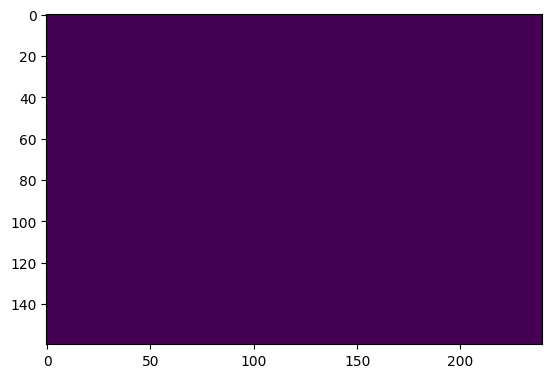

In [ ]:
print(results.shape)

print(torch.max(results[1000]))
print(results[0])

print(results.unique())

plt.imshow(results[0].cpu().detach().numpy())


In [ ]:
M = 8
M2 = 4

In [ ]:
def mean_cosine_similarity(embeddings):
  first_patch_embeddings = embeddings[:, 0, :]
  cosine_sim_matrix = F.cosine_similarity(first_patch_embeddings.unsqueeze(1), first_patch_embeddings.unsqueeze(0), dim=2)
  # remove diagonal since it will always be 1
  mean = (cosine_sim_matrix.sum() - cosine_sim_matrix.trace()) / (cosine_sim_matrix.numel() - cosine_sim_matrix.size(0))
  sense_check = cosine_sim_matrix.trace()/cosine_sim_matrix.size(0) # should be 1
  return mean, sense_check

x = torch.rand(3000, 2, 4)
mean_cosine_similarity(x)


(tensor(0.7777), tensor(1.))

In [ ]:
import torch

def compute_rank(prediction_blocks, threshold=0.95):
  embeddings = prediction_blocks.reshape(-1, prediction_blocks.size(-1))

  sample_mean = torch.mean(embeddings, dim=0, keepdim=True)

  covariance = torch.matmul((embeddings - sample_mean).T, embeddings - sample_mean) / embeddings.size(0)
  eigenvalues, _ = torch.linalg.eigh(covariance)

  total_variance = torch.sum(eigenvalues)

  explained_variance_ratio = eigenvalues / total_variance
  cumulative_explained_variance_ratio = torch.cumsum(explained_variance_ratio, dim=0)

  return torch.sum(cumulative_explained_variance_ratio < threshold) + 1

def compute_rank_per_frame(prediction_blocks, threshold=0.95):
  frame_ranks = torch.zeros(prediction_blocks.size(1), dtype=torch.int64)
  for i in range(prediction_blocks.size(1)):
    frame_ranks[i] = compute_rank(prediction_blocks[:, i, :, :], threshold)
  
  return frame_ranks

x = torch.ones(4, 3, 8, 2758);
y = torch.rand(5, 6, 8, 2758);

print(x.shape)
print(compute_rank(x))
print(compute_rank_per_frame(x))
print(compute_rank(y))
print(compute_rank_per_frame(y))

torch.Size([4, 3, 8, 2758])
tensor(1)
tensor([1, 1, 1])
tensor(2751)
tensor([2757, 2757, 2757, 2757, 2757, 2757])
